In [1]:
!nvidia-smi

Wed Feb  9 14:21:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Resnet34

## Residual Block with 2 convolution layers with filter's size = 3x3

In [3]:
class ResidualBlock3_3(tf.keras.layers.Layer):
    def __init__(self, num_filters, use_1x1conv=False, strides=1):
        super(ResidualBlock3_3, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, 
                                            padding='same', strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3,
                                            padding='same')
        self.conv3 = None 
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1,
                                                padding='same', strides=strides)
            
        self.relu1 = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, X):
        Y = self.relu1(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3 is not None:
            X = self.conv3(X)
        
        Y += X
        return self.relu2(Y)

In [4]:
block = ResidualBlock3_3(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = block(X)
Y.shape

TensorShape([4, 6, 6, 3])

In [5]:
block = ResidualBlock3_3(6, use_1x1conv=True, strides=2)
block(X).shape

TensorShape([4, 3, 3, 6])

## Resnet-34 model

In [24]:
class ResNet34(tf.keras.Model):
    def __init__(self, num_classes):
        '''
        num_classes(int): number of classes in dataset
        '''
        super(ResNet34, self).__init__()

        #First Stage
        self.first_stage_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=7,
                                                       strides=(2, 2), padding='same')
        self.first_stage_batchnorm = tf.keras.layers.BatchNormalization()
        self.first_stage_relu = tf.keras.layers.ReLU()
        self.first_stage_mp = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))

        #Second stage
        self.residual_block_1_s2 = ResidualBlock3_3(num_filters=64)
        self.residual_block_2_s2 = ResidualBlock3_3(num_filters=64)
        self.residual_block_3_s2 = ResidualBlock3_3(num_filters=64)

        #Third stage
        self.residual_block_1_s3 = ResidualBlock3_3(num_filters=128, use_1x1conv=True, strides=2)
        self.residual_block_2_s3 = ResidualBlock3_3(num_filters=128)
        self.residual_block_3_s3 = ResidualBlock3_3(num_filters=128) 
        self.residual_block_4_s3 = ResidualBlock3_3(num_filters=128) 

        #Fourth stage
        self.residual_block_1_s4 = ResidualBlock3_3(num_filters=256, use_1x1conv=True, strides=2)
        self.residual_block_2_s4 = ResidualBlock3_3(num_filters=256)
        self.residual_block_3_s4 = ResidualBlock3_3(num_filters=256) 
        self.residual_block_4_s4 = ResidualBlock3_3(num_filters=256) 
        self.residual_block_5_s4 = ResidualBlock3_3(num_filters=256) 
        self.residual_block_6_s4 = ResidualBlock3_3(num_filters=256) 

        #Fifth stage
        self.residual_block_1_s5 = ResidualBlock3_3(num_filters=512, use_1x1conv=True, strides=2)
        self.residual_block_2_s5 = ResidualBlock3_3(num_filters=512)
        self.residual_block_3_s5 = ResidualBlock3_3(num_filters=512)

        #Fully connected
        self.gbpool = tf.keras.layers.GlobalAvgPool2D()
        self.fc = tf.keras.layers.Dense(units=num_classes, activation='softmax')

    def call(self, X):
        X = self.first_stage_conv(X)
        X = self.first_stage_batchnorm(X)
        X = self.first_stage_relu(X)
        X = self.first_stage_mp(X)

        X = self.residual_block_1_s2(X)
        X = self.residual_block_2_s2(X)
        X = self.residual_block_3_s2(X)

        X = self.residual_block_1_s3(X)
        X = self.residual_block_2_s3(X)
        X = self.residual_block_3_s3(X)
        X = self.residual_block_4_s3(X)

        X = self.residual_block_1_s4(X)
        X = self.residual_block_2_s4(X)
        X = self.residual_block_3_s4(X)
        X = self.residual_block_4_s4(X)
        X = self.residual_block_5_s4(X)
        X = self.residual_block_6_s4(X)

        X = self.residual_block_1_s5(X)
        X = self.residual_block_2_s5(X)
        X = self.residual_block_3_s5(X)

        X = self.gbpool(X)
        return self.fc(X)

    def summary_model(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x)).summary()
    
    def plot_model(self, input_shape, save_path):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.models.Model(inputs=[x], outputs=self.call(x))
        return tf.keras.utils.plot_model(model, to_file=save_path, show_shapes=True)
    

In [25]:
model = ResNet34(2)
model.build(input_shape=(None, 224, 224 ,3))
# model(X)
model.summary_model(input_shape=(224, 224, 3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_293 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_268 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 re_lu_268 (ReLU)            (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 residual_block3_3_130 (Resi  (None, 55, 55, 64)       74368 

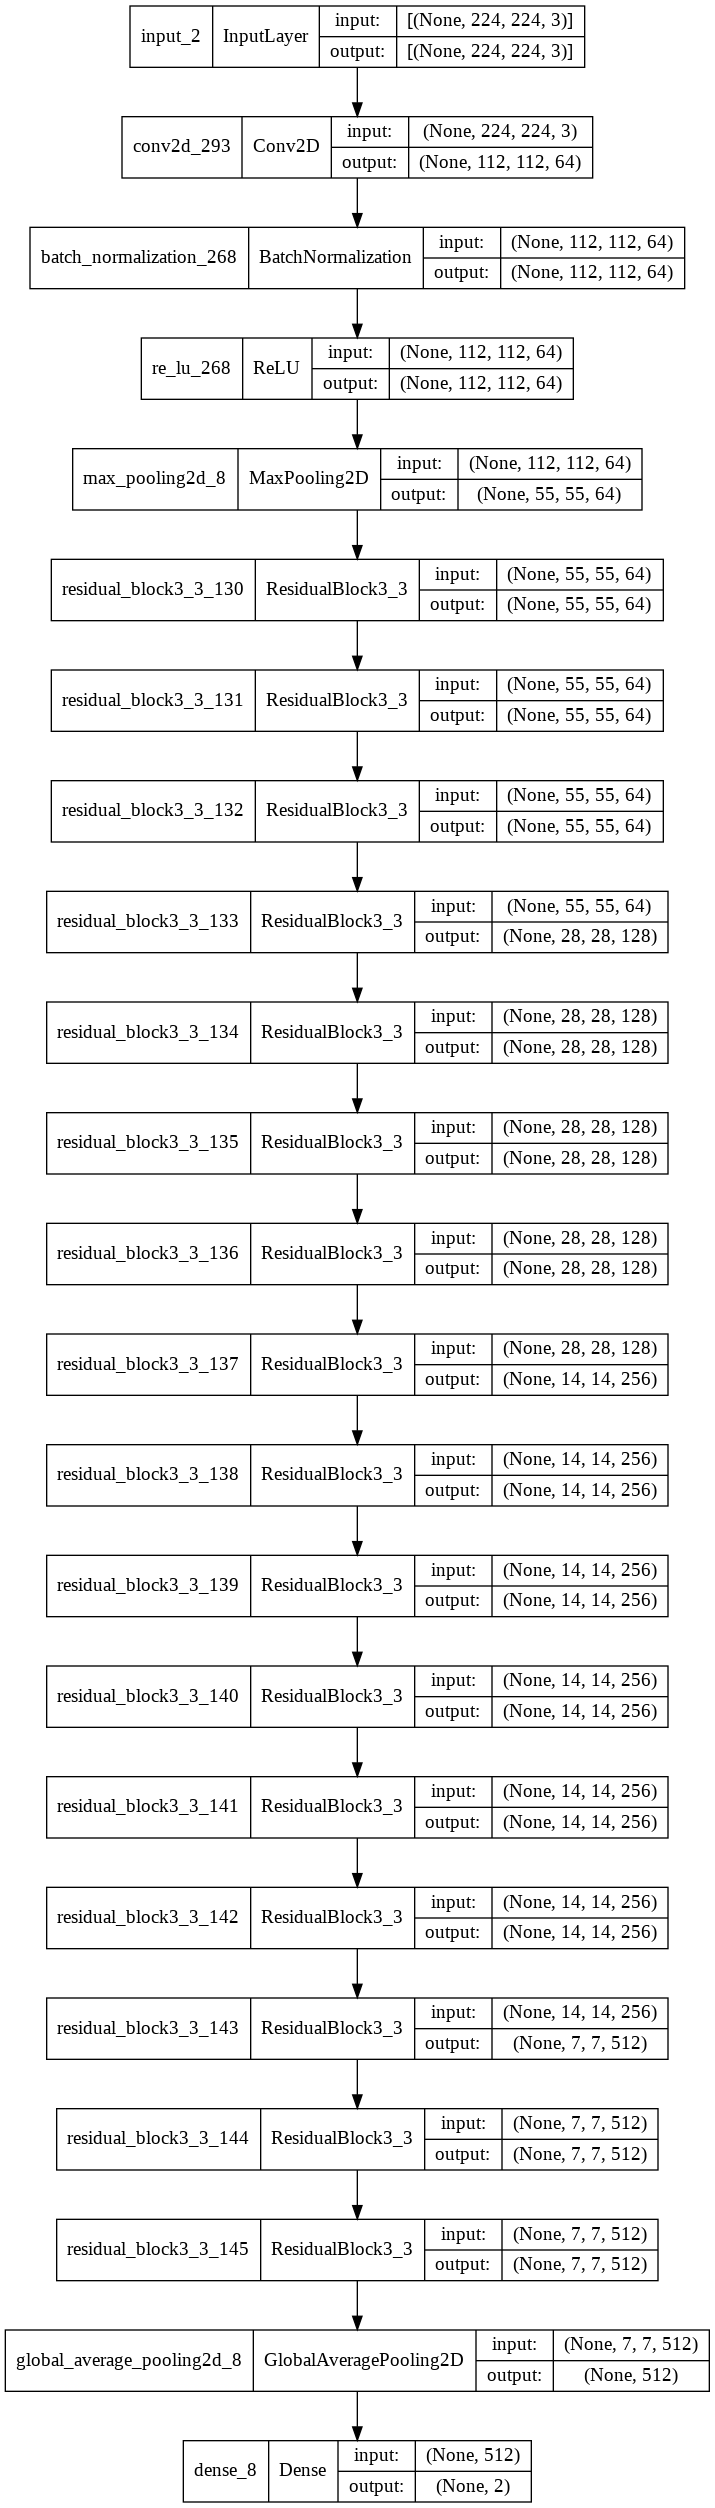

In [27]:
model.plot_model(input_shape=(224, 224, 3), save_path='model.png')

## Download and pre-processing dataset

In [ ]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
!unzip cats_and_dogs_filtered.zip

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True, 
                                   fill_mode='nearest')

train_dataset = train_datagen.flow_from_directory(directory='/content/cats_and_dogs_filtered/train', batch_size=20,
                                                  class_mode='categorical', target_size=(224, 224))

val_datagen = ImageDataGenerator(rescale=1./255)

val_dataset = val_datagen.flow_from_directory(directory='/content/cats_and_dogs_filtered/validation', batch_size=20, 
                                              class_mode='categorical', target_size=(224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
EPOCHS = 20 
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
batch_size = 20

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape: 
        logits = model(x, training=True)
        loss_value = loss_function(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

for epoch in range(EPOCHS):

    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)
        if step % 100 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))     
    train_acc = train_acc_metric.result()
    print("Training acc at step: %.4f" % (float(train_acc),))
    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))      

# Resnet50

## Residual Block with 2 convolution layers with filter's size = 1x1 and 1 convolution layer with filter'size = 3x3

In [36]:
class ResidualBlock1_3_1(tf.keras.layers.Layer):
    def __init__(self, ndim_out, use_conv1x1=False, strides=1):
        super(ResidualBlock1_3_1, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=int(ndim_out/4), kernel_size=(1, 1), 
                                            padding='same', strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(filters=int(ndim_out/4), kernel_size=(3, 3), 
                                            padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=ndim_out, kernel_size=(1, 1), 
                                            padding='same')
        self.conv4 = None

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = None

        self.relu1 = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        self.relu3 = tf.keras.layers.ReLU()

        if use_conv1x1:
            self.conv4 = tf.keras.layers.Conv2D(filters=ndim_out, kernel_size=(1, 1),
                                                padding='same', strides=strides)
            self.bn4 = tf.keras.layers.BatchNormalization()
        
    def call(self, X):
        Y = self.relu1(self.bn1(self.conv1(X)))
        Y = self.relu2(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))

        if self.conv4 is not None:
            X = self.conv4(X)
            X = self.bn4(X)

        Y += X
        return self.relu3(Y)

In [42]:
block = ResidualBlock1_3_1(512, use_conv1x1=True, strides=2)
X = tf.random.uniform((1, 56, 56, 64))
Y = block(X)
Y.shape

TensorShape([1, 28, 28, 512])

In [43]:
class ResNet50(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__() 

        #First Stage
        self.first_stage_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=7,
                                                       strides=(2, 2), padding='same')
        self.first_stage_batchnorm = tf.keras.layers.BatchNormalization()
        self.first_stage_relu = tf.keras.layers.ReLU()
        self.first_stage_mp = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))

        #Second Stage
        self.residual_block_1_s2 = ResidualBlock1_3_1(ndim_out=256, use_conv1x1=True, strides=1)
        self.residual_block_2_s2 = ResidualBlock1_3_1(ndim_out=256)
        self.residual_block_3_s2 = ResidualBlock1_3_1(ndim_out=256)

        #Third Stage
        self.residual_block_1_s3 = ResidualBlock1_3_1(ndim_out=512, use_conv1x1=True, strides=2)
        self.residual_block_2_s3 = ResidualBlock1_3_1(ndim_out=512)
        self.residual_block_3_s3 = ResidualBlock1_3_1(ndim_out=512)
        self.residual_block_4_s3 = ResidualBlock1_3_1(ndim_out=512) 

        #Fouth Stage
        self.residual_block_1_s4 = ResidualBlock1_3_1(ndim_out=1024, use_conv1x1=True, strides=2)
        self.residual_block_2_s4 = ResidualBlock1_3_1(ndim_out=1024)
        self.residual_block_3_s4 = ResidualBlock1_3_1(ndim_out=1024)
        self.residual_block_4_s4 = ResidualBlock1_3_1(ndim_out=1024)
        self.residual_block_5_s4 = ResidualBlock1_3_1(ndim_out=1024)
        self.residual_block_6_s4 = ResidualBlock1_3_1(ndim_out=1024)
        
        #Fifth Stage
        self.residual_block_1_s5 = ResidualBlock1_3_1(ndim_out=2048, use_conv1x1=True, strides=2)
        self.residual_block_2_s5 = ResidualBlock1_3_1(ndim_out=2048)
        self.residual_block_3_s5 = ResidualBlock1_3_1(ndim_out=2048)

        #Fully connected
        self.gbpool = tf.keras.layers.GlobalAvgPool2D()
        self.fc = tf.keras.layers.Dense(units=num_classes, activation='softmax')
    
    def call(self, X):
        X = self.first_stage_conv(X)
        X = self.first_stage_batchnorm(X)
        X = self.first_stage_relu(X)
        X = self.first_stage_mp(X)

        X = self.residual_block_1_s2(X)
        X = self.residual_block_2_s2(X)
        X = self.residual_block_3_s2(X)

        X = self.residual_block_1_s3(X)
        X = self.residual_block_2_s3(X)
        X = self.residual_block_3_s3(X)
        X = self.residual_block_4_s3(X)

        X = self.residual_block_1_s4(X)
        X = self.residual_block_2_s4(X)
        X = self.residual_block_3_s4(X)
        X = self.residual_block_4_s4(X)
        X = self.residual_block_5_s4(X)
        X = self.residual_block_6_s4(X)

        X = self.residual_block_1_s5(X)
        X = self.residual_block_2_s5(X)
        X = self.residual_block_3_s5(X)

        X = self.gbpool(X)
        return self.fc(X)

    def summary_model(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x)).summary()
    
    def plot_model(self, input_shape, save_path):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.models.Model(inputs=[x], outputs=self.call(x))
        return tf.keras.utils.plot_model(model, to_file=save_path, show_shapes=True)


In [46]:
model = ResNet34(2)
model.build(input_shape=(None, 224, 224 ,3))
X = tf.random.uniform((1, 224, 224, 3))
model(X)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.42004666, 0.5799534 ]], dtype=float32)>

In [47]:
model.summary_model(input_shape=(224, 224, 3))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_428 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_394 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 re_lu_391 (ReLU)            (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 residual_block3_3_178 (Resi  (None, 55, 55, 64)       7436

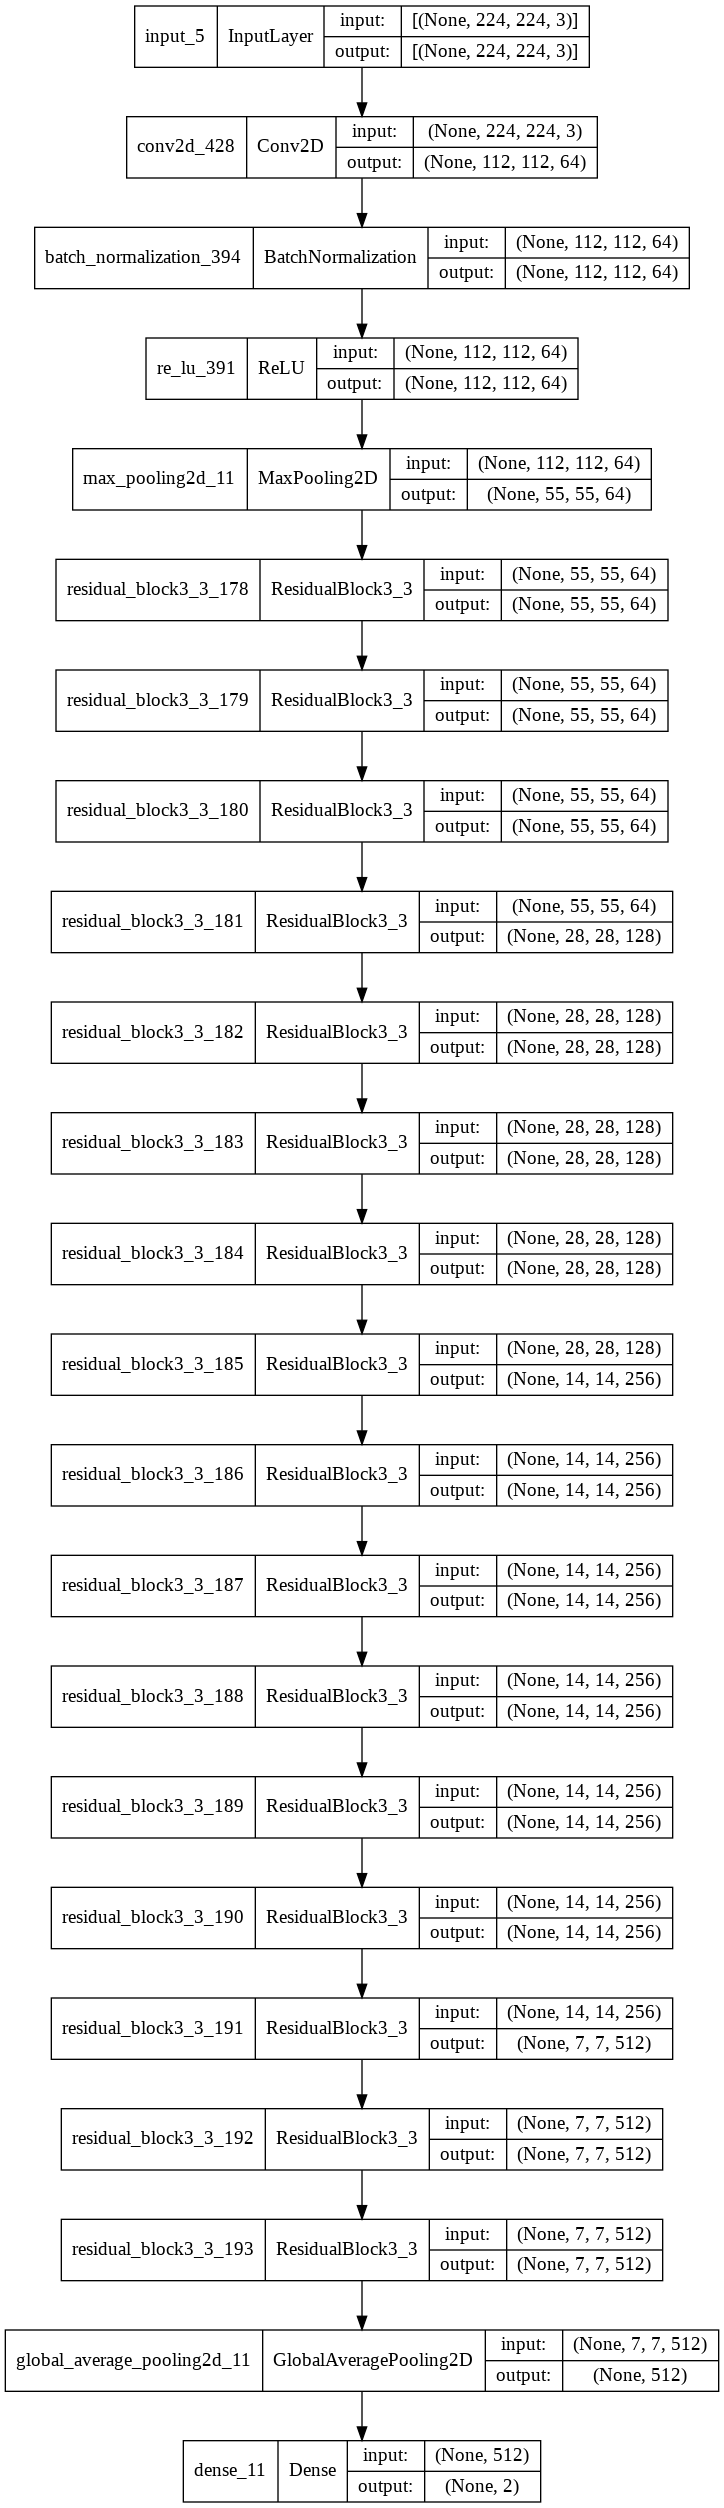

In [49]:
model.plot_model(input_shape=(224, 224, 3), save_path='model.png')